# Задание 4. Предсказание цен на квартиры в Красноярске

### Загрузка датасета

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge, ElasticNet, Lars, BayesianRidge
)
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.regression.linear_model import WLS
from statsmodels.tools import add_constant
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

In [83]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Загрузка и подготовка данных

In [86]:
ids = test_data['id']
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [88]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Количество.комнат,808.0,2.039604e+00,9.961093e-01,1.0,1.00,2.0,3.000,5.0
Студия,808.0,4.084158e-02,1.980457e-01,0.0,0.00,0.0,0.000,1.0
Общая.площадь,808.0,5.078118e+01,1.982751e+01,10.0,37.65,48.0,63.075,120.0
Этаж,808.0,4.894802e+00,3.760826e+00,1.0,2.00,4.0,6.000,24.0
Этажей.в.доме,808.0,8.935644e+00,4.754526e+00,2.0,5.00,9.0,10.000,26.0
Парковка,808.0,1.423267e-01,3.496013e-01,0.0,0.00,0.0,0.000,1.0
Без.ремонта,808.0,1.014851e-01,3.021571e-01,0.0,0.00,0.0,0.000,1.0
Дизайнерский,808.0,2.475248e-02,1.554661e-01,0.0,0.00,0.0,0.000,1.0
Евроремонт,808.0,1.014851e-01,3.021571e-01,0.0,0.00,0.0,0.000,1.0
Косметический,808.0,7.722772e-01,4.196225e-01,0.0,1.00,1.0,1.000,1.0


In [90]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    int64  
 4   Этажей.в.доме              808 non-null    int64  
 5   Парковка                   808 non-null    int64  
 6   Без.ремонта                808 non-null    int64  
 7   Дизайнерский               808 non-null    int64  
 8   Евроремонт                 808 non-null    int64  
 9   Косметический              808 non-null    int64  
 10  Балкон                     808 non-null    int64  
 11  Лоджия                     808 non-null    int64  
 12  Совмещенный.санузел        808 non-null    int64  
 13  Раздельный.санузел         808 non-null    int64  

# Корреляционный анализ:

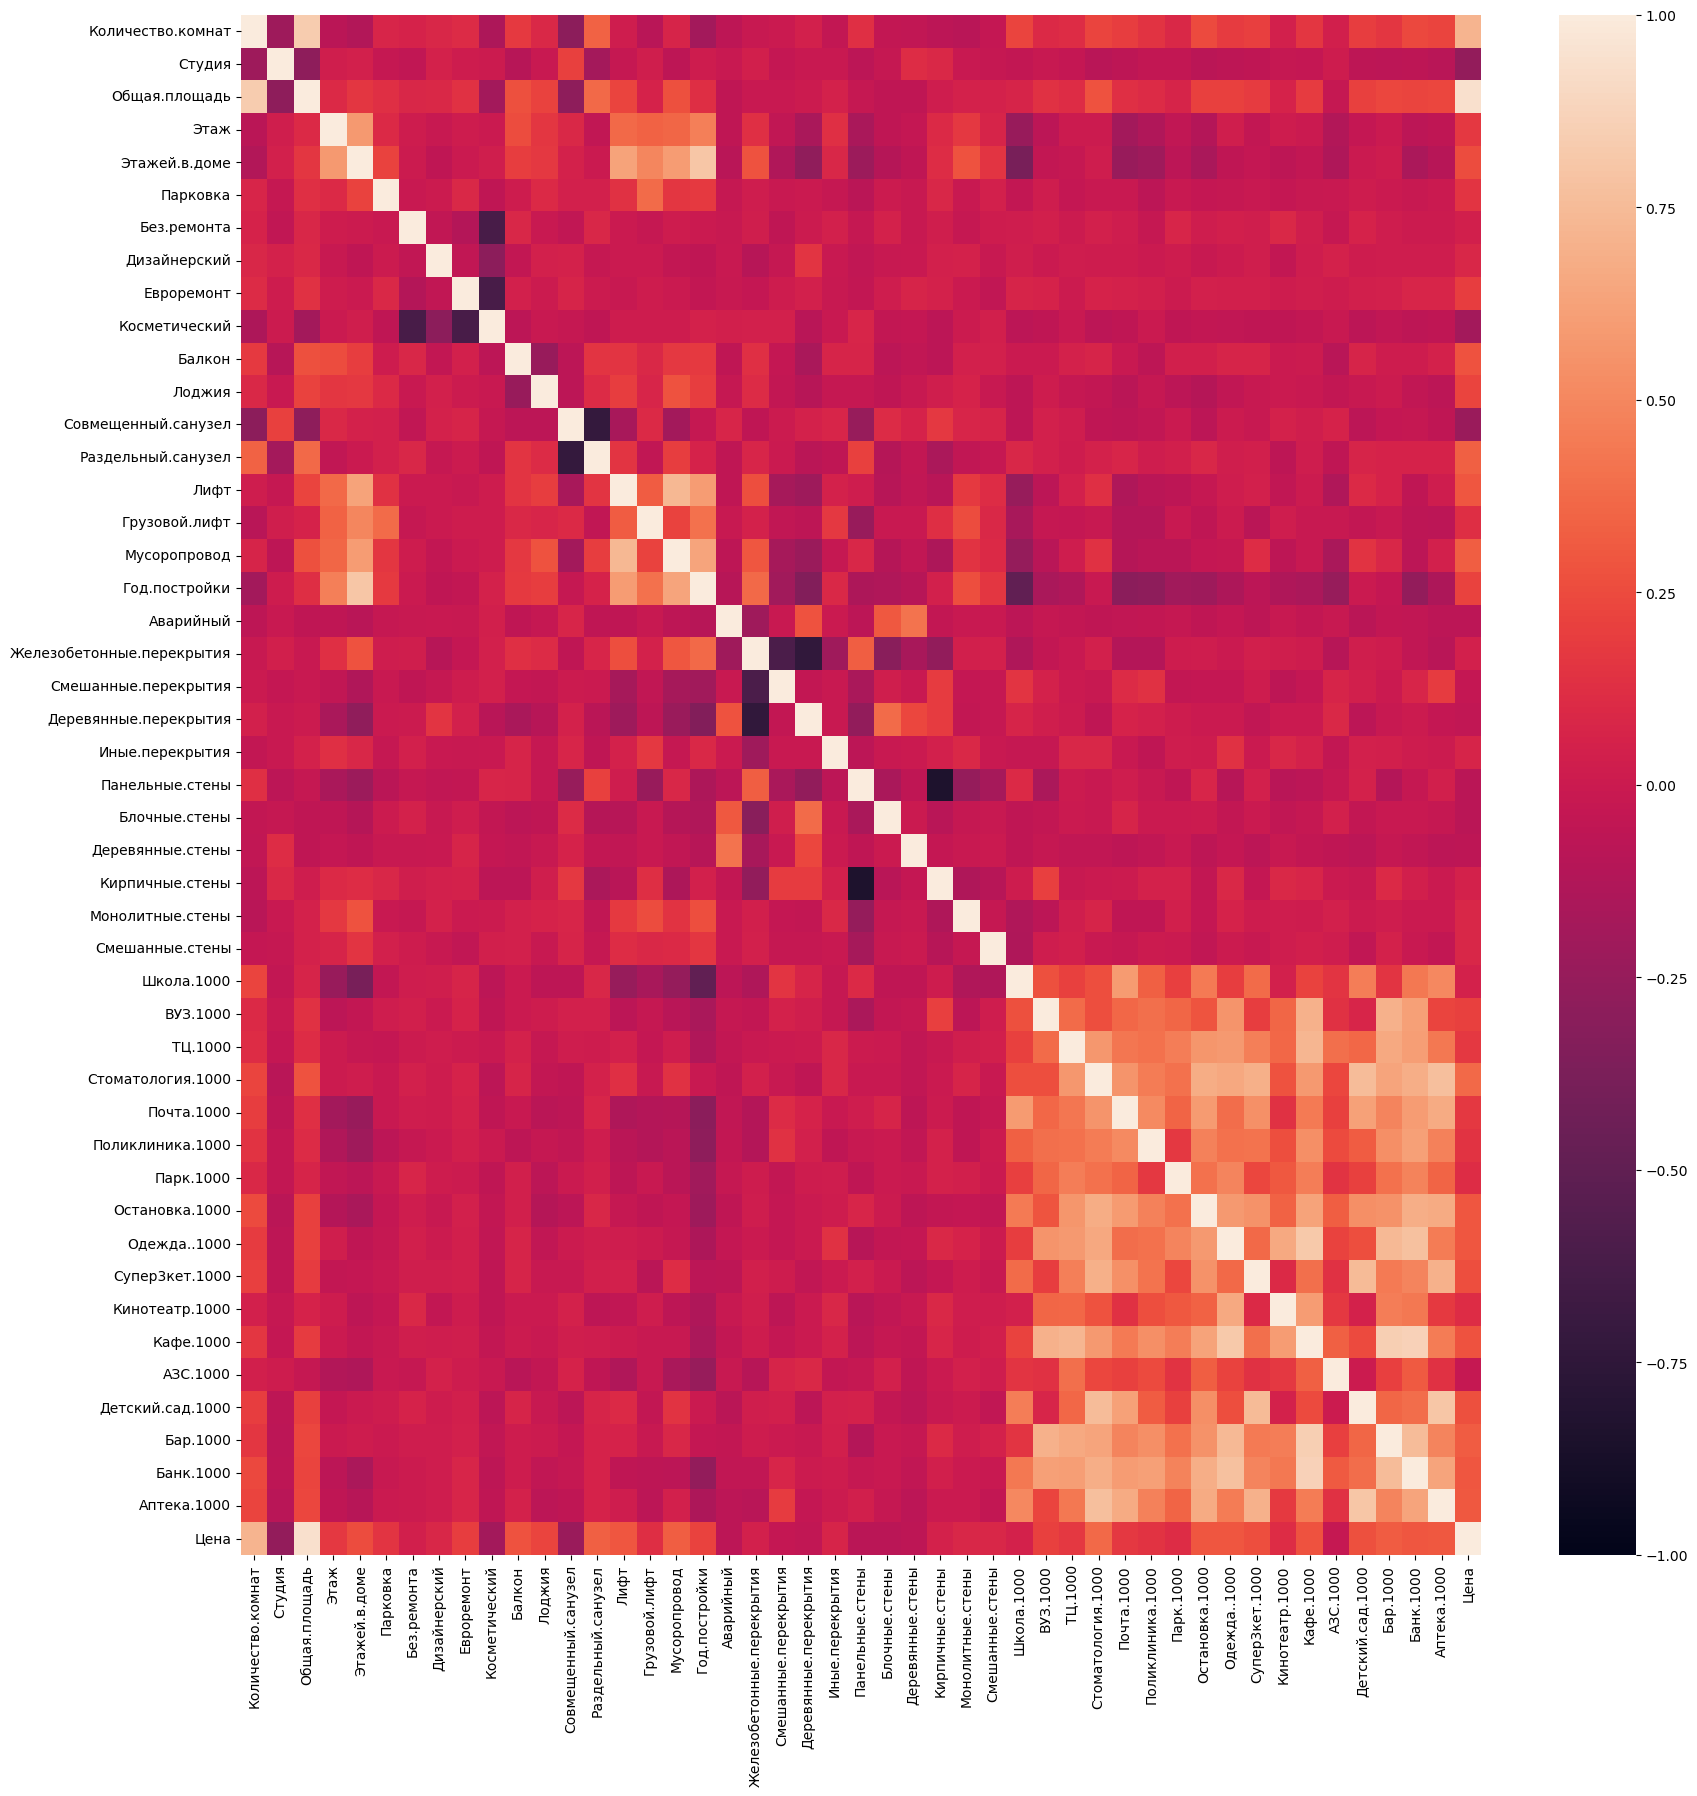

In [93]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_data.corr(), ax=ax, vmin=-1, vmax=1)
plt.show()

In [94]:
corr_matrix = train_data.corr().abs()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(mask).stack().sort_values(ascending=False)
corr_pairs.head(30)

Общая.площадь              Цена                     0.938597
Кафе.1000                  Банк.1000                0.862759
                           Бар.1000                 0.850382
Панельные.стены            Кирпичные.стены          0.838808
Количество.комнат          Общая.площадь            0.828772
Одежда..1000               Кафе.1000                0.818900
Этажей.в.доме              Год.постройки            0.799497
Детский.сад.1000           Аптека.1000              0.798118
Одежда..1000               Банк.1000                0.775691
Стоматология.1000          Аптека.1000              0.772470
Бар.1000                   Банк.1000                0.757517
Стоматология.1000          Детский.сад.1000         0.756102
Супер3кет.1000             Детский.сад.1000         0.748547
Железобетонные.перекрытия  Деревянные.перекрытия    0.740647
Одежда..1000               Бар.1000                 0.736131
Лифт                       Мусоропровод             0.731891
ТЦ.1000                 

In [95]:
target_corr = train_data.corr().abs()['Цена'].sort_values()
target_corr.head(30)

АЗС.1000                     0.025196
Смешанные.перекрытия         0.035399
Без.ремонта                  0.037609
Железобетонные.перекрытия    0.046511
Деревянные.перекрытия        0.051201
Школа.1000                   0.051870
Кирпичные.стены              0.054682
Деревянные.стены             0.064056
Иные.перекрытия              0.068761
Аварийный                    0.073951
Панельные.стены              0.079232
Дизайнерский                 0.079588
Монолитные.стены             0.080280
Смешанные.стены              0.083133
Блочные.стены                0.083979
Парк.1000                    0.110526
Кинотеатр.1000               0.113988
Грузовой.лифт                0.122235
Поликлиника.1000             0.142381
Парковка                     0.155056
Этаж                         0.165215
ТЦ.1000                      0.167013
Почта.1000                   0.170132
Евроремонт                   0.187698
Косметический                0.191723
ВУЗ.1000                     0.207136
Год.постройк

In [99]:
train_data.drop('Смешанные.перекрытия', axis=1, inplace=True)
train_data.drop('Без.ремонта', axis=1, inplace=True)
train_data.drop('Совмещенный.санузел', axis=1, inplace=True)
train_data.drop('Панельные.стены', axis=1, inplace=True)
train_data.drop('Количество.комнат', axis=1, inplace=True)
train_data.drop('Год.постройки', axis=1, inplace=True)
train_data.drop('Деревянные.перекрытия', axis=1, inplace=True)

test_data.drop('Смешанные.перекрытия', axis=1, inplace=True)
test_data.drop('Без.ремонта', axis=1, inplace=True)
test_data.drop('Совмещенный.санузел', axis=1, inplace=True)
test_data.drop('Панельные.стены', axis=1, inplace=True)
test_data.drop('Количество.комнат', axis=1, inplace=True)
test_data.drop('Год.постройки', axis=1, inplace=True)
test_data.drop('Деревянные.перекрытия', axis=1, inplace=True)

In [101]:
corr_matrix = train_data.corr().abs()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(mask).stack().sort_values(ascending=False)
corr_pairs.head(30)

Общая.площадь      Цена                0.938597
Кафе.1000          Банк.1000           0.862759
                   Бар.1000            0.850382
Одежда..1000       Кафе.1000           0.818900
Детский.сад.1000   Аптека.1000         0.798118
Одежда..1000       Банк.1000           0.775691
Стоматология.1000  Аптека.1000         0.772470
Бар.1000           Банк.1000           0.757517
Стоматология.1000  Детский.сад.1000    0.756102
Супер3кет.1000     Детский.сад.1000    0.748547
Одежда..1000       Бар.1000            0.736131
Лифт               Мусоропровод        0.731891
ТЦ.1000            Кафе.1000           0.724524
Супер3кет.1000     Аптека.1000         0.701654
ВУЗ.1000           Бар.1000            0.701056
                   Кафе.1000           0.697181
Стоматология.1000  Супер3кет.1000      0.689517
Остановка.1000     Банк.1000           0.684934
Стоматология.1000  Банк.1000           0.682171
                   Остановка.1000      0.676333
Остановка.1000     Аптека.1000         0

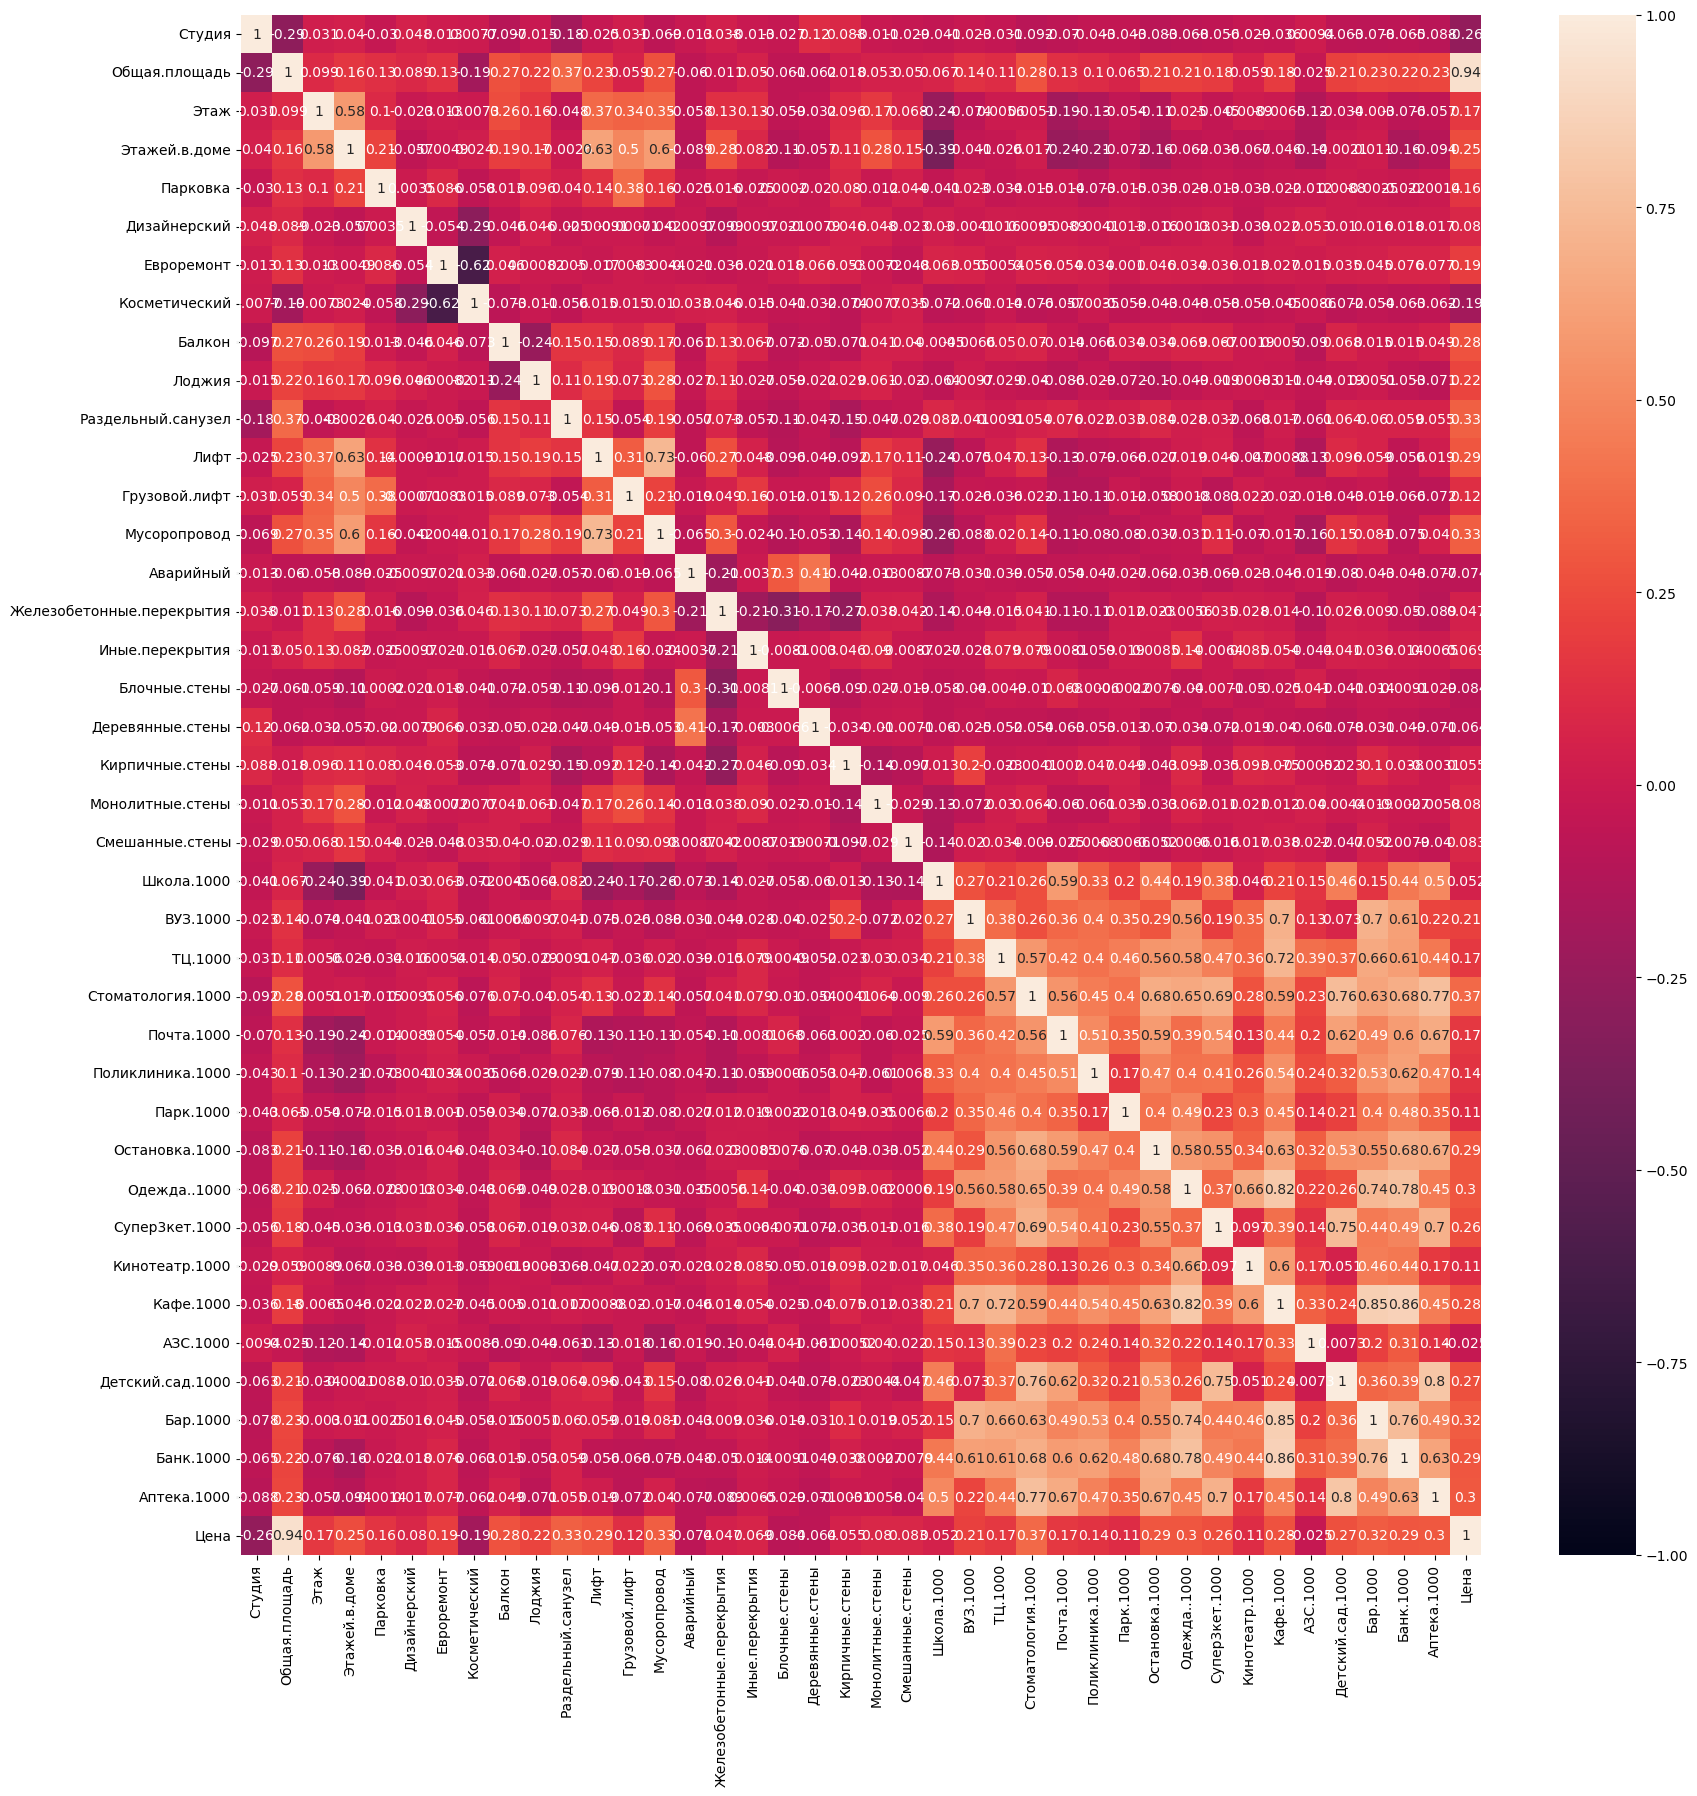

In [103]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_data.corr(), ax=ax, vmin=-1, vmax=1, annot=True)
plt.show()

### Тренировка моделей

In [105]:
X = train_data.drop('Цена', axis=1)
y = train_data['Цена']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [110]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    n, p = X.shape
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return r2, adj_r2, rmse

In [112]:
print("1. Линейная регрессия (МНК)")
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr, n_features_to_select='auto', cv=5)
sfs.fit(X_train, y_train)
selected_features = sfs.get_support()
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
X_val_selected = test_data.iloc[:, selected_features]

lr.fit(X_train_selected, y_train)
lr_r2, lr_adj_r2, lr_rmse = evaluate_model(lr, X_test_selected, y_test)
print(f"R2: {lr_r2:.4f}, Adj.R2: {lr_adj_r2:.4f}, RMSE: {lr_rmse:.4f}")

X_with_const = add_constant(X_train_selected)
lr_sm = sm.OLS(y_train, X_with_const).fit()
print(lr_sm.summary())

1. Линейная регрессия (МНК)
R2: 0.9299, Adj.R2: 0.9205, RMSE: 291292.5556
                            OLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     385.3
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:18:01   Log-Likelihood:                -9079.1
No. Observations:                 646   AIC:                         1.820e+04
Df Residuals:                     626   BIC:                         1.829e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [114]:
print("\n2. Лассо регрессия")
lasso = Lasso()
param_grid = {'alpha': np.logspace(-4, 0, 20)}
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X_train, y_train)
print(f"Best alpha: {lasso_cv.best_params_['alpha']}")
lasso_r2, lasso_adj_r2, lasso_rmse = evaluate_model(lasso_cv.best_estimator_, X_test, y_test)
print(f"R2: {lasso_r2:.4f}, Adj.R2: {lasso_adj_r2:.4f}, RMSE: {lasso_rmse:.4f}")


2. Лассо регрессия
Best alpha: 1.0
R2: 0.9290, Adj.R2: 0.9063, RMSE: 293082.5022


In [116]:
print("\n3. Гребневая регрессия")
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5)
ridge_cv.fit(X_train, y_train)
print(f"Best alpha: {ridge_cv.best_params_['alpha']}")
ridge_r2, ridge_adj_r2, ridge_rmse = evaluate_model(ridge_cv.best_estimator_, X_test, y_test)
print(f"R2: {ridge_r2:.4f}, Adj.R2: {ridge_adj_r2:.4f}, RMSE: {ridge_rmse:.4f}")


3. Гребневая регрессия
Best alpha: 1.0
R2: 0.9298, Adj.R2: 0.9074, RMSE: 291408.3159


In [118]:
print("\n4. Elastic-Net")
elastic = ElasticNet()
param_grid = {
    'alpha': np.logspace(-4, 0, 10),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_cv = GridSearchCV(elastic, param_grid, cv=5)
elastic_cv.fit(X_train, y_train)
print(f"Best params: {elastic_cv.best_params_}")
elastic_r2, elastic_adj_r2, elastic_rmse = evaluate_model(elastic_cv.best_estimator_, X_test, y_test)
print(f"R2: {elastic_r2:.4f}, Adj.R2: {elastic_adj_r2:.4f}, RMSE: {elastic_rmse:.4f}")



4. Elastic-Net
Best params: {'alpha': 0.016681005372000592, 'l1_ratio': 0.3}
R2: 0.9314, Adj.R2: 0.9095, RMSE: 288104.5526


In [120]:
print("\n5. Метод наименьших углов (LARS)")
lars = Lars()
param_grid = {'n_nonzero_coefs': np.arange(1, min(X_train.shape[1]+1, 10))}
lars_cv = GridSearchCV(lars, param_grid, cv=5)
lars_cv.fit(X_train, y_train)
print(f"Best n_nonzero_coefs: {lars_cv.best_params_['n_nonzero_coefs']}")
lars_r2, lars_adj_r2, lars_rmse = evaluate_model(lars_cv.best_estimator_, X_test, y_test)
print(f"R2: {lars_r2:.4f}, Adj.R2: {lars_adj_r2:.4f}, RMSE: {lars_rmse:.4f}")



5. Метод наименьших углов (LARS)
Best n_nonzero_coefs: 9
R2: 0.9264, Adj.R2: 0.9029, RMSE: 298346.0659


In [122]:
print("\n6. Байесовская регрессия")
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_r2, bayesian_adj_r2, bayesian_rmse = evaluate_model(bayesian, X_test, y_test)
print(f"R2: {bayesian_r2:.4f}, Adj.R2: {bayesian_adj_r2:.4f}, RMSE: {bayesian_rmse:.4f}")


6. Байесовская регрессия
R2: 0.9317, Adj.R2: 0.9098, RMSE: 287550.8433


In [124]:
print("\n7. Обобщенная линейная регрессия (обобщенный МНК)")
glm = sm.GLM(y_train, add_constant(X_train)).fit()
glm_r2, glm_adj_r2, glm_rmse = evaluate_model(glm, add_constant(X_test), y_test)
print(f"R2: {glm_r2:.4f}, Adj.R2: {glm_adj_r2:.4f}, RMSE: {glm_rmse:.4f}")
print(glm.summary())



7. Обобщенная линейная регрессия (обобщенный МНК)
R2: 0.9290, Adj.R2: 0.9055, RMSE: 293100.5439
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Цена   No. Observations:                  646
Model:                            GLM   Df Residuals:                      606
Model Family:                Gaussian   Df Model:                           39
Link Function:               Identity   Scale:                      9.6262e+10
Method:                          IRLS   Log-Likelihood:                -9064.8
Date:                Sat, 05 Apr 2025   Deviance:                   5.8335e+13
Time:                        11:18:10   Pearson chi2:                 5.83e+13
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [126]:
print("\n8. Взвешенный МНК")
weights = 1 / np.var(X_train, axis=1)
wls = WLS(y_train, add_constant(X_train), weights=weights).fit()
wls_r2, wls_adj_r2, wls_rmse = evaluate_model(wls, add_constant(X_test), y_test)
print(f"R2: {wls_r2:.4f}, Adj.R2: {wls_adj_r2:.4f}, RMSE: {wls_rmse:.4f}")
print(wls.summary())


8. Взвешенный МНК
R2: 0.9264, Adj.R2: 0.9021, RMSE: 298345.4103
                            WLS Regression Results                            
Dep. Variable:                   Цена   R-squared:                       0.946
Model:                            WLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     270.4
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:18:11   Log-Likelihood:                -8985.7
No. Observations:                 646   AIC:                         1.805e+04
Df Residuals:                     606   BIC:                         1.823e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [ ]:
print("\n9. Полиномиальная регрессия")
poly = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])
param_grid = {'poly__degree': [2, 3]}
poly_cv = GridSearchCV(poly, param_grid, cv=5)
poly_cv.fit(X_train, y_train)
print(f"Best degree: {poly_cv.best_params_['poly__degree']}")
poly_r2, poly_adj_r2, poly_rmse = evaluate_model(poly_cv.best_estimator_, X_test, y_test)
print(f"R2: {poly_r2:.4f}, Adj.R2: {poly_adj_r2:.4f}, RMSE: {poly_rmse:.4f}")


9. Полиномиальная регрессия


In [ ]:
print("\n10. Сплайны")
spline = Pipeline([
    ('spline', SplineTransformer()),
    ('linear', LinearRegression())
])
param_grid = {
    'spline__degree': [3, 4, 5, 6, 7, 8, 9, 10],
    'spline__n_knots': [3, 4, 5]
}
spline_cv = GridSearchCV(spline, param_grid, cv=5)
spline_cv.fit(X_train, y_train)
print(f"Best params: {spline_cv.best_params_}")
spline_r2, spline_adj_r2, spline_rmse = evaluate_model(spline_cv.best_estimator_, X_test, y_test)
print(f"R2: {spline_r2:.4f}, Adj.R2: {spline_adj_r2:.4f}, RMSE: {spline_rmse:.4f}")

In [75]:
print("\n11. Непараметрическая регрессия (LOESS)")
loess_result = lowess(y_train, X_train.iloc[:, 0], frac=0.3)
f = interp1d(loess_result[:, 0], loess_result[:, 1], bounds_error=False)
y_pred = f(X_test.iloc[:, 0])
loess_r2 = r2_score(y_test, y_pred)
loess_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R2: {loess_r2:.4f}, RMSE: {loess_rmse:.4f}")
print("Для непараметрической регрессии не доступны все статистики")


11. Непараметрическая регрессия (LOESS)
R2: 0.0029, RMSE: 1149984.0470
Для непараметрической регрессии не доступны все статистики


E:\anaconda\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [77]:
results = pd.DataFrame({
    'Model': [
        'Linear Regression', 'Lasso', 'Ridge', 'Elastic-Net', 'LARS',
        'Bayesian Ridge', 'GLM', 'WLS', 'Polynomial', 'Spline', 'LOESS'
    ],
    'R2': [
        lr_r2, lasso_r2, ridge_r2, elastic_r2, lars_r2,
        bayesian_r2, glm_r2, wls_r2, poly_r2, spline_r2, loess_r2
    ],
    'Adj.R2': [
        lr_adj_r2, lasso_adj_r2, ridge_adj_r2, elastic_adj_r2, lars_adj_r2,
        bayesian_adj_r2, glm_adj_r2, wls_adj_r2, poly_adj_r2, spline_adj_r2, np.nan
    ],
    'RMSE': [
        lr_rmse, lasso_rmse, ridge_rmse, elastic_rmse, lars_rmse,
        bayesian_rmse, glm_rmse, wls_rmse, poly_rmse, spline_rmse, loess_rmse
    ]
})

print(results.round(4))

                Model      R2  Adj.R2          RMSE
0   Linear Regression  0.9110  0.8991  3.435073e+05
1               Lasso  0.9162  0.8895  3.332995e+05
2               Ridge  0.9170  0.8905  3.317417e+05
3         Elastic-Net  0.9182  0.8920  3.293943e+05
4                LARS  0.9102  0.8815  3.450524e+05
5      Bayesian Ridge  0.9159  0.8890  3.340506e+05
6                 GLM  0.9162  0.8885  3.333104e+05
7                 WLS  0.9146  0.8864  3.365510e+05
8          Polynomial -5.5404 -7.6311  2.945301e+06
9              Spline  0.8988  0.8664  3.664273e+05
10              LOESS  0.0029     NaN  1.149984e+06


In [79]:
final_predictions = lr.predict(X_val_selected)
results = pd.DataFrame({
    'id': ids,
    'Цена': final_predictions
})
results.to_csv('result.csv', index=False)